# Preprocessing
After collecting the original data, I applied a bandpass filter from 20-200 hz and notch filters at 60, 120, and 180 hz. I then extracted 2 second oral preparation and swallow signals from the data using visual inspection. Within the data directory, each folder name is the substance name and the volume swallowed (if applicable) of the data contained within it.

In [1]:
import os
import pandas as pd
import random
import shutil

data_path = r'C:\Users\chloe\OneDrive\Desktop\swallow EMG\data\07_18_25\extracted signals'
class_folders = os.listdir(data_path)
example_class = class_folders[0]
example_files = os.listdir(os.path.join(data_path, example_class))

# File organization
print(class_folders)
print(example_class)
print(example_files)

def num_files(data_path):
    df = []
    
    for class_name in os.listdir(data_path):
        class_path = os.path.join(data_path, class_name)
        if os.path.isdir(class_path):
            num_files = len(os.listdir(class_path))
            df.append((class_name, num_files))

    return pd.DataFrame(df, columns=['Class', 'Num Files'])

num_files(data_path)

['apple 10', 'apple 20', 'carrot 5', 'chewing 0', 'dry swallow 0', 'grape 5', 'jelly 10', 'milk 10', 'milk 20', 'oral prep 0', 'popcorn 1', 'redu oral prep 0', 'water 10', 'water 20', 'yogurt 10', 'yogurt 20']
apple 10
['1.txt', '10.txt', '11.txt', '12.txt', '13.txt', '14.txt', '15.txt', '16.txt', '17.txt', '18.txt', '19.txt', '2.txt', '20.txt', '21.txt', '22.txt', '23.txt', '24.txt', '25.txt', '26.txt', '27.txt', '28.txt', '29.txt', '3.txt', '30.txt', '4.txt', '5.txt', '6.txt', '7.txt', '8.txt', '9.txt']


,Class,Num Files
0,apple 10,30
1,apple 20,30
2,carrot 5,30
3,chewing 0,30
4,dry swallow 0,30
5,grape 5,32
6,jelly 10,30
7,milk 10,29
8,milk 20,30
9,oral prep 0,304


# Feature Extraction
I got some of these features and functions from this link: https://www.kaggle.com/code/calulamabel/emg-hand-gesture-classification/notebook

In [2]:
import numpy as np

# mean absolute value
def mav(data):
    return np.mean(np.abs(data), axis=0)

# root mean square
def rms(data):
    return np.sqrt(np.mean(data**2,axis=0))  
    
# wavelength
def wavelength(data):
    return np.sum(np.abs(np.diff(data)), axis=0)
    
# zero crossing rate
def zcr(data):
    return np.sum(np.diff(np.sign(data), axis=0) != 0, axis=0) / (len(data)-1)

# variance
def var(data):
    return np.var(data, axis=0)

# absolute difference
def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data,axis=0)),axis=0)

# mean frequency
def mean_freq(data, fs=500):
    freqs = np.fft.rfftfreq(len(data), d=1/fs)
    spectrum = np.abs(np.fft.rfft(data))**2
    return np.sum(freqs * spectrum) / np.sum(spectrum)

# median frequency
def median_freq(data, fs=500):
    freqs = np.fft.rfftfreq(len(data), d=1/fs)
    spectrum = np.abs(np.fft.rfft(data))**2
    cumulative = np.cumsum(spectrum)
    total = cumulative[-1]
    med_idx = np.searchsorted(cumulative, total / 2)
    return freqs[med_idx]

# peak frequency
def peak_freq(data, fs=500):
    freqs = np.fft.rfftfreq(len(data), d=1/fs)
    spectrum = np.abs(np.fft.rfft(data))**2
    peak_idx = np.argmax(spectrum)
    return freqs[peak_idx]

# shannon entropy
def shannon_entropy(signal, num_bins=30):
    hist, bin_edges = np.histogram(signal, bins=num_bins, density=True)
    prob = hist * np.diff(bin_edges)  

    prob = prob[prob > 0]

    entropy = -np.sum(prob * np.log2(prob))
    return entropy

# integrated emg
def iemg(signal):
    return np.sum(np.abs(signal))

In [3]:
df = pd.DataFrame()

class_map = {}
i = 0

for class_name in os.listdir(data_path):
    if class_name == 'oral prep 0':
        continue
        
    class_path = os.path.join(data_path, class_name)
    class_str = class_name.rstrip('.txt')
    parts = class_str.split()
    volume = parts[-1]
    substance = ' '.join(parts[:-1])
    
    for sample_name in os.listdir(class_path):
        sample_df = pd.read_csv(os.path.join(data_path, class_name, sample_name), delimiter = ",", header = None)
        sample_df.columns = [i+1 for i in range(sample_df.shape[1])]
        if substance not in class_map:
            class_map[substance] = i
            i += 1
        
        sample_df['substance'] = substance
        sample_df['volume'] = volume
        sample_df_grouped = sample_df.groupby(['substance', 'volume'])
        
        features_df = sample_df_grouped.agg(['min', 'max', mav, rms, wavelength, zcr, var, abs_diffs_signal, mean_freq, median_freq, peak_freq, shannon_entropy, iemg])
        df = pd.concat([df, features_df])

df.reset_index(inplace=True)

In [4]:
print(class_map)

{'apple': 0, 'carrot': 1, 'chewing': 2, 'dry swallow': 3, 'grape': 4, 'jelly': 5, 'milk': 6, 'popcorn': 7, 'redu oral prep': 8, 'water': 9, 'yogurt': 10}


In [5]:
df['substance'] = df['substance'].map(class_map)
df

substance volume         1                                                \
                           min       max        mav        rms    wavelength   
0           0     10  -89.8215   73.5244  10.123081  15.526914   8511.370464   
1           0     10 -113.9200   86.1073   9.896790  16.791919   8262.519721   
2           0     10  -82.3953   84.7438  10.532140  16.572327   8938.223938   
3           0     10 -194.0030  125.6940  11.846242  20.842131   9634.231501   
4           0     10 -117.7260   84.5021  11.854229  18.994828   9543.440074   
..        ...    ...       ...       ...        ...        ...           ...   
440        10     20  -69.3289   69.5755  10.175371  15.426147   8874.451929   
441        10     20  -86.3076   74.0248  11.288252  18.020237   9792.563997   
442        10     20  -93.5527   91.9620  11.081596  17.163182   8838.968969   
443        10     20  -95.3684   61.4933  11.031382  16.758005   9634.328738   
444        10     20  -95.7571   91.9919  13.782139  20.737838  11234.928474   

                                            ...           22             \
          zcr         var abs_diffs_signal  ...          rms wavelength   
0    0.271271  241.085047      8511.370464  ...  4634.416598     426580   
1    0.290290  281.968302      8262.519721  ...  4996.715521     449540   
2    0.274274  274.641479      8938.223938  ...  5597.687773     391580   
3    0.250250  434.394440      9634.231501  ...  6691.171078     458780   
4    0.257257  360.801618      9543.440074  ...  6675.993619     353780   
..        ...         ...              ...  ...          ...        ...   
440  0.279279  237.965865      8874.451929  ...  4313.488379     329560   
441  0.273273  324.728936      9792.563997  ...  5367.578821     396620   
442  0.254254  294.572930      8838.968969  ...  5302.465577     390740   
443  0.288288  280.830702      9634.328738  ...  5118.934928     390040   
444  0.265265  430.057924     11234.928474  ...  4801.379552     462560   

                                                                              \
          zcr           var abs_diffs_signal mean_freq median_freq peak_freq   
0    0.067067  2.147730e+07           426580  6.866916         4.0       2.5   
1    0.040040  2.476357e+07           449540  5.226880         1.5       1.5   
2    0.036036  3.078873e+07           391580  3.448059         1.0       0.5   
3    0.031031  4.119861e+07           458780  4.439223         1.0       0.5   
4    0.026026  4.449073e+07           353780  2.640694         1.0       0.5   
..        ...           ...              ...       ...         ...       ...   
440  0.043043  1.854732e+07           329560  6.230145         3.5       2.5   
441  0.036036  2.879051e+07           396620  5.266034         2.5       2.0   
442  0.035035  2.811149e+07           390740  4.882148         3.0       2.5   
443  0.047047  2.616131e+07           390040  5.639875         3.5       2.5   
444  0.058058  2.290177e+07           462560  6.510082         4.0       2.5   

                              
    shannon_entropy     iemg  
0          4.040291  3322060  
1          4.537548  4038860  
2          4.487950  4577860  
3          4.410476  5437880  
4          4.641191  5531540  
..              ...      ...  
440        3.997013  3136980  
441        4.062512  3865400  
442        4.641988  4293940  
443        4.344892  3813460  
444        4.518855  3783080  

[445 rows x 288 columns]

In [6]:
from sklearn import svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

svm_model = svm.SVC(kernel='linear', random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=3)
dt_model = DecisionTreeClassifier(random_state=42)
nb_model = GaussianNB()
regression_model = LogisticRegression(random_state=42, max_iter=500)
gb_model = GradientBoostingClassifier(random_state=42)

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

label_names = ['Substance', 'Volume']

# accuracies
models = []
model_exact_accuracies = [] # predicts both labels right

def train_and_plot_multioutput_model(model, model_name, cm=True):
    model.fit(x_train_scaled, y_train)
    y_pred = model.predict(x_test_scaled)

    # Exact match accuracy (all labels correct)
    exact_match_accuracy = np.mean(np.all(y_test.values == y_pred, axis=1))

    # Per-label accuracy
    per_label_accuracy = (y_test == y_pred).mean(axis=0)
    average_label_accuracy = per_label_accuracy.mean()

    models.append(model_name)
    model_exact_accuracies.append(exact_match_accuracy * 100)

    print(model_name)
    print(f'Exact Match Accuracy: {exact_match_accuracy:.4f}')
    print(f'Average Per-Label Accuracy: {average_label_accuracy:.4f}')
    print(f'Per-Label Accuracies: {per_label_accuracy.values if hasattr(per_label_accuracy, "values") else per_label_accuracy}')
    print('----------------------------')

    # Confusion matrices for each label
    if cm == True:
        for i, col in enumerate(y_test.columns):
            cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
            plt.figure(figsize=(4, 3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f'{model_name} Confusion Matrix, {label_names[i]}')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.show()

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

x = df.drop(columns=['volume', 'substance'])
y = df[['substance', 'volume']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print(x_train_scaled.shape)  
print(y_train.shape)  

(356, 286)
(356, 2)


C:\Users\chloe\AppData\Local\Temp\ipykernel_14128\2049000297.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  x = df.drop(columns=['volume', 'substance'])


In [32]:
# indexes for volume labels in confusion matrix

volume_labels = np.unique(y_test['volume'])
df_volume_labels = pd.DataFrame(volume_labels, columns=['volume'])
print(df_volume_labels)

   volume
0       0
1       1
2       5
3      10
4      20


SVM
Exact Match Accuracy: 0.8539
Average Per-Label Accuracy: 0.9101
Per-Label Accuracies: [0.92134831 0.8988764 ]
----------------------------


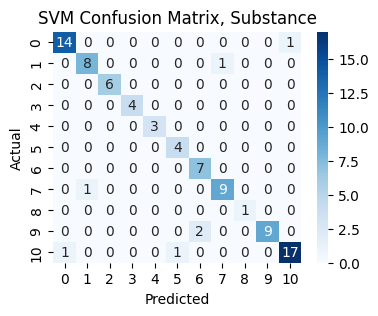

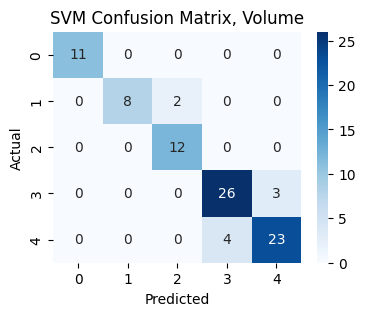

KNN
Exact Match Accuracy: 0.8652
Average Per-Label Accuracy: 0.8764
Per-Label Accuracies: [0.86516854 0.88764045]
----------------------------


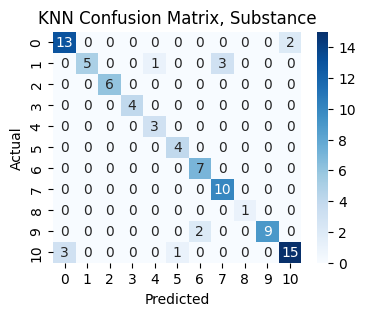

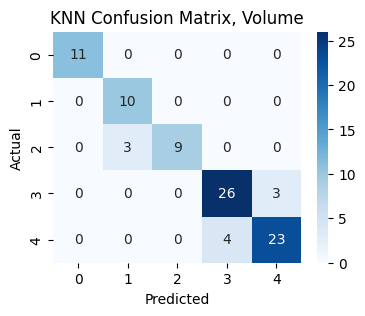

Decision Tree
Exact Match Accuracy: 0.6966
Average Per-Label Accuracy: 0.8371
Per-Label Accuracies: [0.82022472 0.85393258]
----------------------------


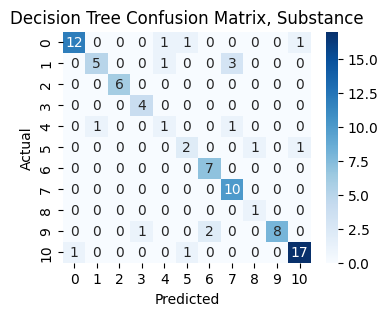

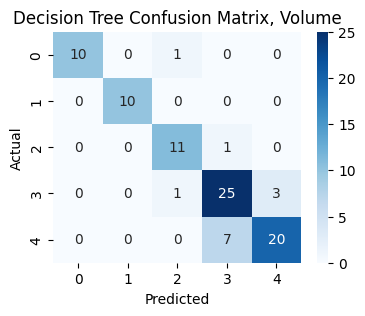

Naive Bayes
Exact Match Accuracy: 0.6292
Average Per-Label Accuracy: 0.7584
Per-Label Accuracies: [0.82022472 0.69662921]
----------------------------


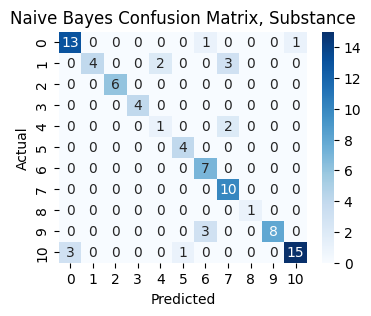

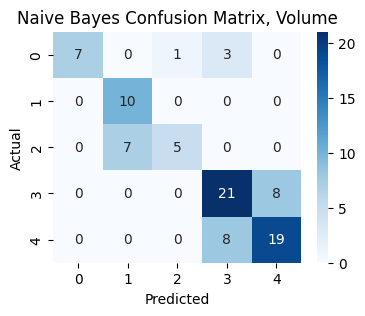

Logistic Regression
Exact Match Accuracy: 0.8652
Average Per-Label Accuracy: 0.9157
Per-Label Accuracies: [0.92134831 0.91011236]
----------------------------


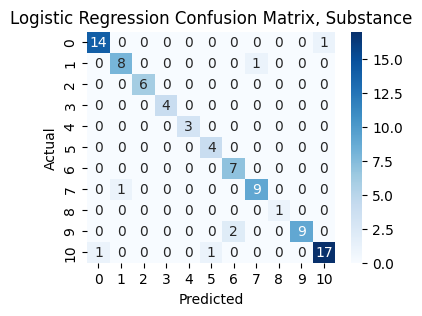

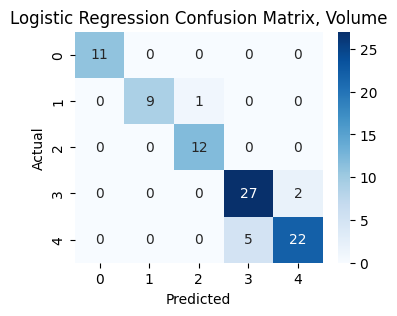

Gradient Boosting
Exact Match Accuracy: 0.7978
Average Per-Label Accuracy: 0.8708
Per-Label Accuracies: [0.84269663 0.8988764 ]
----------------------------


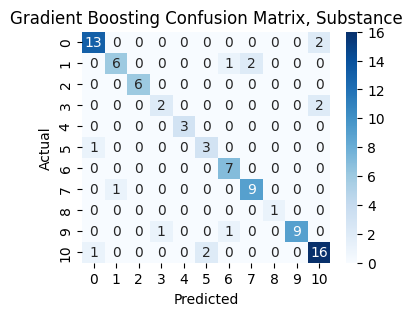

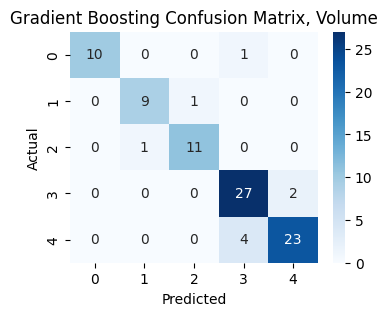

In [27]:
from sklearn.multioutput import MultiOutputClassifier

model = MultiOutputClassifier(svm_model)
train_and_plot_multioutput_model(model, 'SVM', cm=True)

model = MultiOutputClassifier(knn_model)
train_and_plot_multioutput_model(model, 'KNN', cm=True)

model = MultiOutputClassifier(dt_model)
train_and_plot_multioutput_model(model, 'Decision Tree', cm=True)

model = MultiOutputClassifier(nb_model)
train_and_plot_multioutput_model(model, 'Naive Bayes', cm=True)

model = MultiOutputClassifier(regression_model)
train_and_plot_multioutput_model(model, 'Logistic Regression', cm=True)

model = MultiOutputClassifier(gb_model)
train_and_plot_multioutput_model(model, 'Gradient Boosting', cm=True)

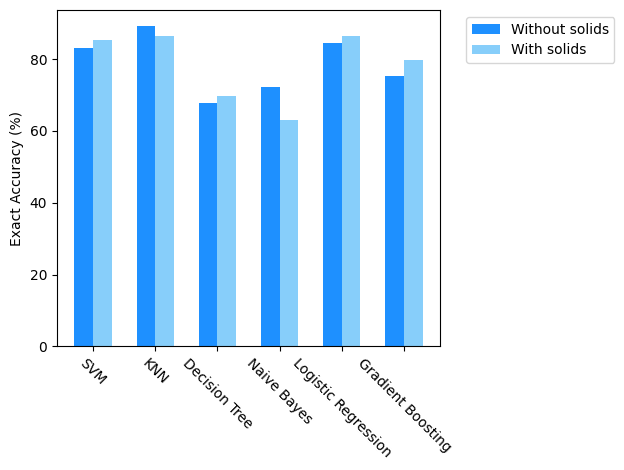

In [28]:
bandpass_accuracies_df = pd.read_csv('multioutput_bandpass_accuracies.csv', header=None)
bandpass_accuracies = bandpass_accuracies_df.iloc[0].tolist()

x = np.arange(len(models)) 
width = 0.3 

# Plot bars side by side
plt.bar(x - width/2, bandpass_accuracies, width, label='Without solids', color='dodgerblue')
plt.bar(x + width/2, model_exact_accuracies, width, label='With solids', color='lightskyblue')

# Add labels
plt.xticks(x, models, rotation=-45)
plt.ylabel('Exact Accuracy (%)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()